<a href="https://colab.research.google.com/github/Team-Takeoff/Capstone/blob/Dave/data_acquisition/Aircraft_Extract_Join.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aircraft Data Acquisition and Merge with Flight Data

In this notebook we attempt to pull some details about the aircraft that are used in flights.  This might be helpful in understanding delay potential. We identified a site that has a lookup for Domestic Aircraft with passenger capacity:
https://aerobasegroup.com/tail-number-lookup

Tail numbers were saved off from our Visual Analysis of the Data. We attempt to accomplish the following:

1) Acquire data about each aircraft
2) Inspect data for missing values
3) Impute missing values
4) Review Statistics about the obtained aircraft and airlines

In [ ]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import time, os, json
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
path_to_files_json = ''
files = json.load(open(path_to_files_json,'r'))


In [ ]:
files

{'BTS': {'OnTime': 'drive/Shareddrives/STUDENT-Capstone SS23/BTS_data/OnTime_Parquet/OnTime.parquet/part-00000-4aeede3c-0ec0-4f85-bd4e-d756fcb6bf48-c000.snappy.parquet',
  'DFW_test': '/content/drive/Shareddrives/STUDENT-Capstone SS23/BTS_data/OnTime_Parquet/OnTime_Filtered_DFW_Only_2023/ONT_DF_2023_DFW.parquet',
  'OrigDest': '/content/drive/Shareddrives/STUDENT-Capstone SS23/BTS_data/OrigDestination'},
 'Weather': {'Dest': '/content/drive/Shareddrives/STUDENT-Capstone SS23/Weather_Data/wo_Destination.parquet',
  'Origin': '/content/drive/Shareddrives/STUDENT-Capstone SS23/Weather_Data/wo_Origin.parquet',
  'DFW_Origin': '/content/drive/Shareddrives/STUDENT-Capstone SS23/Weather_Data/wo_Origin_DFW_uniq.parquet',
  'DFW_train': '/content/drive/Shareddrives/STUDENT-Capstone SS23/Weather_Data/DFW_Weather_10_19.parquet',
  'DFW_test': '/content/drive/Shareddrives/STUDENT-Capstone SS23/Weather_Data/DFW_Weather_23.parquet'},
 'Aircraft': {'Filtered_Tails': '/content/drive/Shareddrives/STUDE

## 1.0  Data Acquisition

In [ ]:
# Tail_numbers were saved from the OnTime data
tn = pd.read_csv(files['Aircraft']['All_Tails'])
tn.columns = ['Tail_Number']

In [ ]:
tn.Tail_Number.values[800:]

array(['N934EV', 'N931EV', 'N980EV', ..., 'N8AWAA', 'N999JB', 'N973JB'],
      dtype=object)

Note - I ran the following code several times to ensure I was getting good results so the starting value for Tail No below may not be 0

In [ ]:
with open('airspecs.csv', 'a') as file:
    for craft in tqdm(list(tn.Tail_Number.values[2800:])):
        resp = requests.get(f'https://aerobasegroup.com/tail-number-lookup/{craft}')
        soup = BeautifulSoup(resp.content)
        tbods = soup.find_all('td')
        line = craft
        for tag in tbods:
            if tag.get_text().strip()=='Manufacturer':
                line += ',' + tag.next_sibling.next_sibling.get_text()

            if tag.get_text().strip() == 'Model':
                line += ',' + tag.next_sibling.next_sibling.get_text()

            if tag.get_text().strip() == 'Aircraft Type':
                line += ',' + tag.next_sibling.next_sibling.get_text()

            if tag.get_text().strip() == 'No. Seats':
                line += ',' + tag.next_sibling.next_sibling.get_text()

            if tag.get_text().strip() == 'Weight Class':
                line += ',' + tag.next_sibling.next_sibling.get_text()

            if tag.get_text().strip() == 'Engine Type':
                line += ',' + tag.next_sibling.next_sibling.get_text()

            if tag.get_text().strip() == 'No. Engines':
                line += ',' + tag.next_sibling.next_sibling.get_text()

        line += '\n'
        file.write(line)
        soup.decompose()
        time.sleep(np.random.randint(2,7))




100%|██████████| 6739/6739 [8:51:36<00:00,  4.73s/it]  


## 2.0 Data Inspection

In [ ]:
# import the data we obtained from the cell above
ac = pd.read_csv(files['Aircraft']['Extracted_Tails'])

In [ ]:
ac.head()

,tail_no,mfr,model,type,passengers,wght_class,engine_type,no_engines
0,N301DQ,BOEING,737-732,Fixed Wing (Multi Engine),149.0,CLASS 3,Turbofan,2.0
1,N554NW,BOEING,757-251,Fixed Wing (Multi Engine),178.0,CLASS 3,Turbofan,2.0
2,N760NC,MCDONNELL DOUGLAS,DC-9-51,Fixed Wing (Multi Engine),139.0,CLASS 3,Turbojet,2.0
3,N956DL,MCDONNELL DOUGLAS AIRCRAFT CO,MD-88,Fixed Wing (Multi Engine),142.0,CLASS 3,Turbofan,2.0
4,N394DA,BOEING,737-832,Fixed Wing (Multi Engine),189.0,CLASS 3,Turbofan,2.0


In [ ]:
ac.tail_no.unique()

array(['N301DQ', 'N554NW', 'N760NC', ..., 'N8AWAA', 'N999JB', 'N973JB'],
      dtype=object)

In [ ]:
ac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9539 entries, 0 to 9538
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tail_no      9539 non-null   object 
 1   mfr          7654 non-null   object 
 2   model        7654 non-null   object 
 3   type         7994 non-null   object 
 4   passengers   7994 non-null   float64
 5   wght_class   7654 non-null   object 
 6   engine_type  7649 non-null   object 
 7   no_engines   7994 non-null   float64
dtypes: float64(2), object(6)
memory usage: 596.3+ KB


In [ ]:
import missingno as miss

In [ ]:
def missing_stats(df):
    total = len(df)
    for  c in df.columns:
        no_missing = len(df[df[c].isna()])
        prop = no_missing/total
        print(f' Missing {c}: {no_missing} | {100 * prop:.2f}%')


In [ ]:
missing_stats(ac)

 Missing tail_no: 0 | 0.00%
 Missing mfr: 1885 | 19.76%
 Missing model: 1885 | 19.76%
 Missing type: 1545 | 16.20%
 Missing passengers: 1545 | 16.20%
 Missing wght_class: 1885 | 19.76%
 Missing engine_type: 1890 | 19.81%
 Missing no_engines: 1545 | 16.20%
 Missing tail_prefix: 0 | 0.00%


One fifth of the data is at least one value.  The smallest number of missing for any column is 1545.  Let's confirm if this is the same as the number of total records with no values

In [ ]:
cols = ac.columns[1:]
len(ac[ac[cols].isnull().apply(lambda x: all(x), axis=1) == True])

1545

Indeed this is the case. The FAA registers US planes with an 'N' prefix.  non-N prefixes are assumed to be foreign.  Let's see the breakdown of these

In [ ]:
ac['tail_prefix'] = ac['tail_no'].apply(lambda x: x[0])
agg_ac = ac.groupby('tail_prefix').describe()
agg_ac

passengers                                                       \
                 count        mean         std    min     25%    50%    75%   
tail_prefix                                                                   
2                 84.0  182.000000    0.000000  182.0  182.00  182.0  182.0   
3                 38.0  132.157895   22.140249  100.0  100.00  147.0  147.0   
4                 12.0  160.833333   25.693414   85.0  167.75  172.0  172.0   
7                  3.0  100.000000   84.870490    2.0   75.50  149.0  149.0   
8                 16.0  149.562500   48.714089    4.0  167.75  172.0  172.0   
9                  7.0    2.571429    0.975900    2.0    2.00    2.0    3.0   
A                  0.0         NaN         NaN    NaN     NaN    NaN    NaN   
D                  0.0         NaN         NaN    NaN     NaN    NaN    NaN   
N               7834.0  151.364948  104.787705    0.0   80.00  149.0  189.0   

                   no_engines                                              
               max      count      mean      std  min  25%  50%  75%  max  
tail_prefix                                                                
2            182.0       84.0  2.000000  0.00000  2.0  2.0  2.0  2.0  2.0  
3            147.0       38.0  2.000000  0.00000  2.0  2.0  2.0  2.0  2.0  
4            172.0       12.0  2.000000  0.00000  2.0  2.0  2.0  2.0  2.0  
7            149.0        3.0  1.666667  0.57735  1.0  1.5  2.0  2.0  2.0  
8            172.0       16.0  1.937500  0.25000  1.0  2.0  2.0  2.0  2.0  
9              4.0        7.0  1.000000  0.00000  1.0  1.0  1.0  1.0  1.0  
A              NaN        0.0       NaN      NaN  NaN  NaN  NaN  NaN  NaN  
D              NaN        0.0       NaN      NaN  NaN  NaN  NaN  NaN  NaN  
N            563.0     7834.0  1.905668  0.51174  0.0  2.0  2.0  2.0  9.0

In [ ]:
# Number of non-FAA registered aircraft
agg_ac[agg_ac.index.str.startswith('N')==False][('passengers','count')].sum()

160.0

In [ ]:
#create a filtered ac dataframe for only N-registered aircraft
N_ac = ac[ac['tail_prefix']=='N']
print(f'Number of Unique Aircraft {len(N_ac.tail_no.unique())}')
N_ac.head()


Number of Unique Aircraft 9162


,tail_no,mfr,model,type,passengers,wght_class,engine_type,no_engines,tail_prefix
0,N301DQ,BOEING,737-732,Fixed Wing (Multi Engine),149.0,CLASS 3,Turbofan,2.0,N
1,N554NW,BOEING,757-251,Fixed Wing (Multi Engine),178.0,CLASS 3,Turbofan,2.0,N
2,N760NC,MCDONNELL DOUGLAS,DC-9-51,Fixed Wing (Multi Engine),139.0,CLASS 3,Turbojet,2.0,N
3,N956DL,MCDONNELL DOUGLAS AIRCRAFT CO,MD-88,Fixed Wing (Multi Engine),142.0,CLASS 3,Turbofan,2.0,N
4,N394DA,BOEING,737-832,Fixed Wing (Multi Engine),189.0,CLASS 3,Turbofan,2.0,N


In [ ]:
missing_stats(N_ac)

 Missing tail_no: 0 | 0.00%
 Missing mfr: 1669 | 18.21%
 Missing model: 1669 | 18.21%
 Missing type: 1329 | 14.50%
 Missing passengers: 1329 | 14.50%
 Missing wght_class: 1669 | 18.21%
 Missing engine_type: 1674 | 18.27%
 Missing no_engines: 1329 | 14.50%
 Missing tail_prefix: 0 | 0.00%


<Axes: >

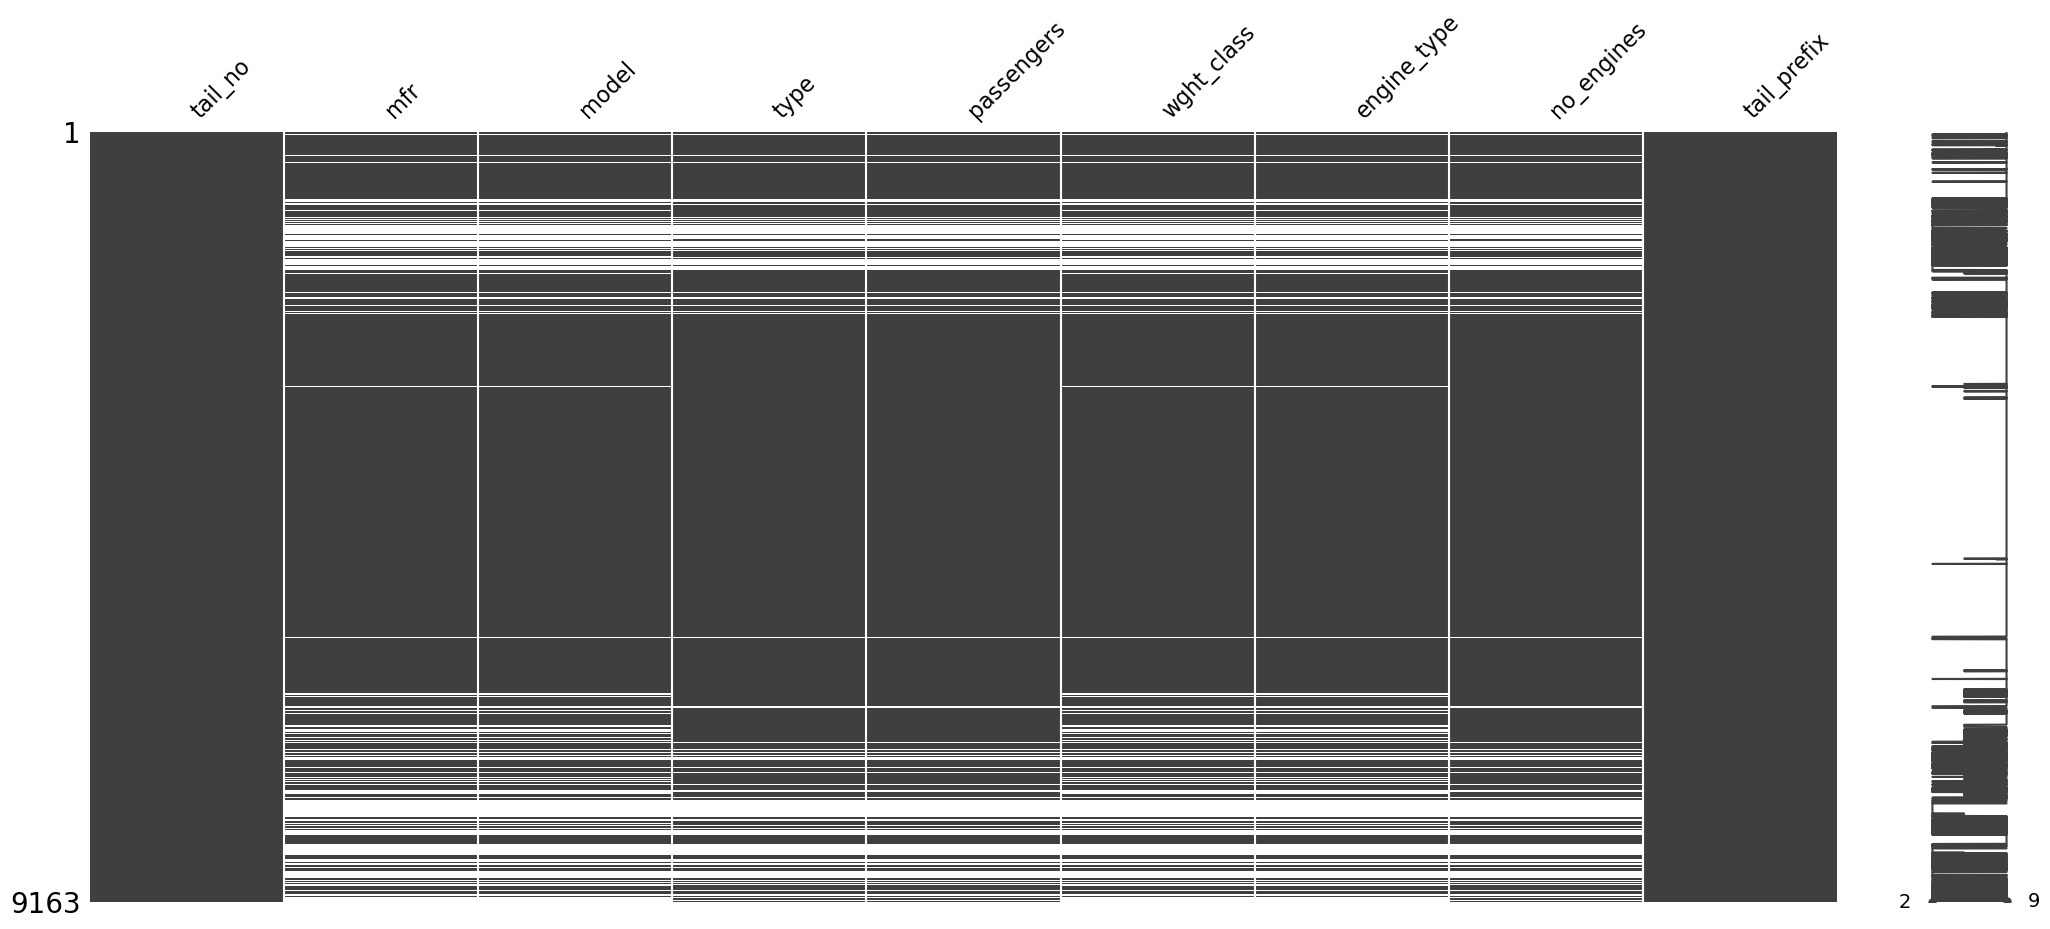

In [ ]:
miss.matrix(N_ac)

There were quite a few records that didn't have any information. This was due to the aircraft being de-registered.  I didn't find any sources that could provide historic information.

In [ ]:
# Note use spark.read.parquet method if this is being run on free version of colab
df = pd.read_parquet(files['BTS']['Ontime'])

In [ ]:
complete = N_ac[N_ac['passengers'].isna()==False]
tails = complete.tail_no.unique()

In [ ]:
ndf = pd.merge(df, complete, how='inner', left_on='Tail_Number', right_on='tail_no')

In [ ]:
ndf[ndf['DepDelay'] > 100][['DepDelay','passengers']].corr()

,DepDelay,passengers
DepDelay,1.000000,-0.008042
passengers,-0.008042,1.000000


# Attempted Join with FAA Data

Originally, we ran selenium scripts to obtain other data about the tail_numbers such as date of manufacture and other specifics about the aircraft. There was a max to the number of hits we could use Selenium on decided to abandon the effort due to time constraints.  The work below was leveraging what we did have to combine the two aircraft datasets

In [ ]:
# Read in data from the other source of aircrafts

faa = pd.read_csv(files['Aircraft']['FAA_Tails'])
faa.tail(10)

,Tail_NO,Year_Built,Manufacturer,Model
4174,N928AA,None,CIRCUIT MICHAEL P,AMER AEROLTS EAGLE
4175,N932AA,1983,ULTRALIGHTS INC,EAGLE 2-PLACE
4176,N3PGAA,NaN,NaN,NaN
4177,N3PKAA,NaN,NaN,NaN
4178,N3PJAA,NaN,NaN,NaN
4179,N933AA,1983,FINGER LAKES AIRSPORTS INC,EAGLE 2-PLACE
4180,N3PMAA,NaN,NaN,NaN
4181,N8AVAA,NaN,NaN,NaN
4182,N8AWAA,NaN,NaN,NaN
4183,N973JB,1966,CESSNA,310L


In [ ]:
faa.drop_duplicates(['Tail_NO'], keep='first',inplace=True)

In [ ]:
# Merge the N-Registered planes which were obtained from the aerospace webiste and the faa website
comb = pd.merge(N_ac, faa, how='left', left_on='tail_no', right_on='Tail_NO')

In [ ]:
# Consolidate the Manufacturer fields into just one
comb['mfr'] = comb.apply(lambda x: x['mfr'] if pd.isnull(x['mfr'])==False else x[' Manufacturer'],axis=1)

In [ ]:
# Same with the aircraft model
comb['model'] = comb.apply(lambda x: x['model'] if pd.isnull(x['model'])==False else x['Model'], axis=1)

In [ ]:
missing_stats(comb)

 Missing tail_no: 0 | 0.00%
 Missing mfr: 923 | 10.07%
 Missing model: 923 | 10.07%
 Missing type: 1329 | 14.50%
 Missing passengers: 1329 | 14.50%
 Missing wght_class: 1669 | 18.21%
 Missing engine_type: 1674 | 18.27%
 Missing no_engines: 1329 | 14.50%
 Missing tail_prefix: 0 | 0.00%
 Missing Tail_NO: 5354 | 58.43%
 Missing Year_Built: 6265 | 68.37%
 Missing  Manufacturer: 6265 | 68.37%
 Missing Model: 6265 | 68.37%


In [ ]:
# Save a copy of the aircraft we have no manufactureer info on; we can see if it's available on the FAA Site
missing_file = ''
comb[comb['mfr'].isna()==True]['tail_no'].to_csv(missing_file,index=False)

In [ ]:
comb

,tail_no,mfr,model,type,passengers,wght_class,engine_type,no_engines,tail_prefix,Tail_NO,Year_Built,Manufacturer,Model
0,N301DQ,BOEING,737-732,Fixed Wing (Multi Engine),149.0,CLASS 3,Turbofan,2.0,N,N301DQ,None,BOEING,737-732
1,N554NW,BOEING,757-251,Fixed Wing (Multi Engine),178.0,CLASS 3,Turbofan,2.0,N,N554NW,2001,BOEING,757-251
2,N760NC,MCDONNELL DOUGLAS,DC-9-51,Fixed Wing (Multi Engine),139.0,CLASS 3,Turbojet,2.0,N,N760NC,1976,MCDONNELL DOUGLAS,DC-9-51
3,N956DL,MCDONNELL DOUGLAS AIRCRAFT CO,MD-88,Fixed Wing (Multi Engine),142.0,CLASS 3,Turbofan,2.0,N,N956DL,1990,MCDONNELL DOUGLAS AIRCRAFT CO,MD-88
4,N394DA,BOEING,737-832,Fixed Wing (Multi Engine),189.0,CLASS 3,Turbofan,2.0,N,N394DA,2000,BOEING,737-832
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9158,N3PMAA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N3PMAA,NaN,NaN,NaN
9159,N8AVAA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N8AVAA,NaN,NaN,NaN
9160,N8AWAA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,N8AWAA,NaN,NaN,NaN
9161,N999JB,START FLUG GMBH,H101 SALTO,Glider,1.0,CLASS 1,NaN,0.0,N,NaN,NaN,NaN,NaN


Let's take a look at aircraft for which we do have manufacturer specified.  To make things manageable, I'll consolidate both manufacturer and model into one column

In [ ]:
comb = comb[comb['mfr'].isna()==False]
comb['mfr-model'] = comb['mfr'] + "-" + comb['model']

In [ ]:
comb.sample()

,tail_no,mfr,model,type,passengers,wght_class,engine_type,no_engines,tail_prefix,Tail_NO,Year_Built,Manufacturer,Model,mfr-model
4580,N7731A,BOEING,737-76N,Fixed Wing (Multi Engine),149.0,CLASS 3,Turbofan,2.0,N,NaN,NaN,NaN,NaN,BOEING-737-76N


In [ ]:
new_comb = pd.get_dummies(comb, columns=['mfr-model'])

In [ ]:
new_comb = new_comb.iloc[:,1:]

In [ ]:
new_comb

,passengers,mfr-model_3D ROBOTICS-SOLO,mfr-model_4 SEASONS AVIATION-STARFLIGHT XC2000,mfr-model_AAI CORP DBA TEXTRON SYSTS UNM-AEROSONDE MK 47G,mfr-model_AERO COMMANDER-1121,mfr-model_AERO COMMANDER-500 S,mfr-model_AERO COMMANDER-500-B,mfr-model_AERO COMMANDER-690A,mfr-model_AEROSPATIALE-AS 355F1,mfr-model_AGUSTA SPA-A109E,...,mfr-model_WACO-YKC-S,mfr-model_WACO-YOC,mfr-model_WHEELER E GBALLATIN H J-RV6A,mfr-model_WHEELER NORTH-RV-3B,mfr-model_WOBIG WAYNE R-FALCON-XP,mfr-model_YABORA INDUSTRIA AERONAUTICA S-ERJ 170-200 LL,mfr-model_YABORA INDUSTRIA AERONAUTICA S-ERJ 170-200 LR,mfr-model_YUNEEC INTERNATIONAL CO LTD-Q500 TYPHOON,mfr-model_ZING AEROSPORTS LLC-ZR-70,mfr-model_ZITZMANN/LAWRENCE/GALEOTI-FALCON XP
0,149.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,178.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,139.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,142.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,189.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9152,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9153,6.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9157,NaN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9161,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##Imputation of Aircraft Data

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

iter_impute =  IterativeImputer(max_iter=100, random_state=0)

In [ ]:
comb.passengers.describe()

count    7786.000000
mean      152.298099
std       104.431939
min         0.000000
25%        80.000000
50%       149.000000
75%       189.000000
max       563.000000
Name: passengers, dtype: float64

array([[<Axes: title={'center': 'passengers'}>]], dtype=object)

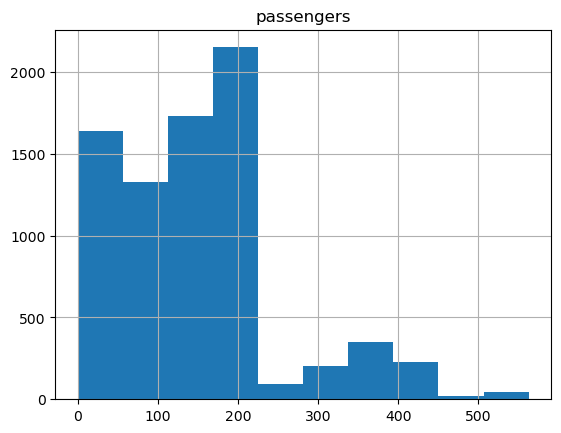

In [ ]:
comb.hist('passengers')

In [ ]:
# Most of the aircraft have capacity between 150 and 200 passengers.  There were quite a few that have 0

comb[comb['passengers']==0].sample(5)
# Looks like the 0 is incorrect - the BD-500-1A10 can have 110 passengers, the A321-253NX can have 296 as example.  We'll need to impute these values so we should set them to NaN values

,tail_no,mfr,model,type,passengers,wght_class,engine_type,no_engines,tail_prefix,Tail_NO,Year_Built,Manufacturer,Model,mfr-model
9087,N947AA,BELL,212,Unknown,0.0,NaN,NaN,0.0,N,N947AA,None,BELL,212,BELL-212
7208,N427AN,AIRBUS,A321-253NX,Unknown,0.0,NaN,NaN,0.0,N,N427AN,2020,AIRBUS,A321-253NX,AIRBUS-A321-253NX
7135,N141DU,AIRBUS CANADA LTD PTNRSP,BD-500-1A10,Unknown,0.0,NaN,NaN,0.0,N,N141DU,None,AIRBUS CANADA LTD PTNRSP,BD-500-1A10,AIRBUS CANADA LTD PTNRSP-BD-500-1A10
7677,N434AN,AIRBUS,A321-253NX,Unknown,0.0,NaN,NaN,0.0,N,N434AN,2021,AIRBUS,A321-253NX,AIRBUS-A321-253NX
6706,N119DU,AIRBUS CANADA LTD PTNRSP,BD-500-1A10,Unknown,0.0,NaN,NaN,0.0,N,N119DU,2019,AIRBUS CANADA LTD PTNRSP,BD-500-1A10,AIRBUS CANADA LTD PTNRSP-BD-500-1A10


In [ ]:
comb['passengers'] = comb['passengers'].apply(lambda x: np.nan if x == 0 else x)

In [ ]:
comb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8240 entries, 0 to 9162
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tail_no        8240 non-null   object 
 1   mfr            8240 non-null   object 
 2   model          8240 non-null   object 
 3   type           7786 non-null   object 
 4   passengers     7471 non-null   float64
 5   wght_class     7494 non-null   object 
 6   engine_type    7489 non-null   object 
 7   no_engines     7786 non-null   float64
 8   tail_prefix    8240 non-null   object 
 9   Tail_NO        2946 non-null   object 
 10  Year_Built     2898 non-null   object 
 11   Manufacturer  2898 non-null   object 
 12  Model          2898 non-null   object 
 13  mfr-model      8240 non-null   object 
dtypes: float64(2), object(12)
memory usage: 965.6+ KB


In [ ]:
comb.groupby('mfr-model')['passengers'].describe().head(30)

,count,mean,std,min,25%,50%,75%,max
mfr-model,,,,,,,,
3D ROBOTICS-SOLO,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4 SEASONS AVIATION-STARFLIGHT XC2000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAI CORP DBA TEXTRON SYSTS UNM-AEROSONDE MK 47G,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AERO COMMANDER-1121,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AERO COMMANDER-500 S,1.0,7.0,NaN,7.0,7.0,7.0,7.0,7.0
AERO COMMANDER-500-B,1.0,7.0,NaN,7.0,7.0,7.0,7.0,7.0
AERO COMMANDER-690A,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AEROSPATIALE-AS 355F1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AGUSTA SPA-A109E,1.0,8.0,NaN,8.0,8.0,8.0,8.0,8.0


In [ ]:
# Found the N831MQ was a 3D Robotics Plane (which is a Drone Craft Manufacturer) verifying the flight data
df[df['Tail_Number']=='N831MQ'].head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,Flight_Number_Reporting_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,Dest,DestCityName,DestState,DestStateFips,DestStateName,DestWac,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelay,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,LongestAddGTime,DivAirportLandings,DivReachedDest,DivActualElapsedTime,DivArrDelay,DivDistance,Div1Airport,Div1AirportID,Div1AirportSeqID,Div1WheelsOn,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime,Div2WheelsOff,Div2TailNum,Div3Airport,Div3AirportID,Div3AirportSeqID,Div3WheelsOn,Div3TotalGTime,Div3LongestGTime,Div3WheelsOff,Div3TailNum,Div4Airport,Div4AirportID,Div4AirportSeqID,Div4WheelsOn,Div4TotalGTime,Div4LongestGTime,Div4WheelsOff,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum
8598025,2013,1,2,10,7,2013-02-10,MQ,20398,MQ,N831MQ,2719,11298,1129803,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,15412,1541202,35412,TYS,"Knoxville, TN",TN,47,Tennessee,54,730,728,-2.0,0.0,0.0,-1.0,0700-0759,25.0,753,1032,3.0,1025,1035,10.0,10.0,0.0,0.0,1000-1059,0.0,,0.0,115.0,127.0,99.0,1.0,772.0,4,NaN,NaN,NaN,NaN,NaN,,None,None,0.0,None,None,None,None,,None,None,,None,None,,,,None,None,,None,None,,,,None,None,,None,None,,,,None,None,,None,None,,,,None,None,,None,None,,
8598030,2013,1,2,15,5,2013-02-15,MQ,20398,MQ,N831MQ,2719,11298,1129803,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,15412,1541202,35412,TYS,"Knoxville, TN",TN,47,Tennessee,54,730,729,-1.0,0.0,0.0,-1.0,0700-0759,16.0,745,1020,3.0,1025,1023,-2.0,0.0,0.0,-1.0,1000-1059,0.0,,0.0,115.0,114.0,95.0,1.0,772.0,4,NaN,NaN,NaN,NaN,NaN,,None,None,0.0,None,None,None,None,,None,None,,None,None,,,,None,None,,None,None,,,,None,None,,None,None,,,,None,None,,None,None,,,,None,None,,None,None,,
8598035,2013,1,2,20,3,2013-02-20,MQ,20398,MQ,N831MQ,2719,11298,1129803,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,15412,1541202,35412,TYS,"Knoxville, TN",TN,47,Tennessee,54,730,727,-3.0,0.0,0.0,-1.0,0700-0759,18.0,745,1013,2.0,1025,1015,-10.0,0.0,0.0,-1.0,1000-1059,0.0,,0.0,115.0,108.0,88.0,1.0,772.0,4,NaN,NaN,NaN,NaN,NaN,,None,None,0.0,None,None,None,None,,None,None,,None,None,,,,None,None,,None,None,,,,None,None,,None,None,,,,None,None,,None,None,,,,None,None,,None,None,,
8598044,2013,1,2,1,5,2013-02-01,MQ,20398,MQ,N831MQ,2721,11298,1129803,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,10136,1013603,30136,ABI,"Abilene, TX",TX,48,Texas,74,1740,1740,0.0,0.0,0.0,0.0,1700-1759,10.0,1750,1819,2.0,1830,1821,-9.0,0.0,0.0,-1.0,1800-1859,0.0,,0.0,50.0,41.0,29.0,1.0,158.0,1,NaN,NaN,NaN,NaN,NaN,,None,None,0.0,None,None,None,None,,None,None,,None,None,,,,None,None,,None,None,,,,None,None,,None,None,,,,None,None,,None,None,,,,None,None,,None,None,,
8598072,2013,1,2,1,5,2013-02-01,MQ,20398,MQ,N831MQ,2722,11298,1129803,30194,DFW,"Dallas/Fort Worth, TX",TX,48,Texas,74,11982,1198202,31982,GRK,"Killeen, TX",TX,48,Texas,74,1450,1506,16.0,16.0,1.0,1.0,1400-1459,8.0,1514,1541,2.0,1535,1543,8.0,8.0,0.0,0.0,1500-1559,0.0,,0.0,45.0,37.0,27.0,1.0,134.0,1,NaN,NaN,NaN,NaN,NaN,,None,None,0.0,None,None,None,None,,None,None,,None,None,,,,None,None,,None,None,,,,None,None,,None,None,,,,None,None,,None,None,,,,None,None,,None,None,,


In [ ]:
aircraft_filepath = ''
cols = [x for x in comb.columns if x not in [' Manufacturer','Model']]
comb[cols].to_csv(aircraft_filepath, index=False)


## Get Targeted List of Manufacturers

When we reviewed the data, we noticed there were several smaller aircraft that weren't large commerical aircraft (see two cells up and the one aircraft from 3D Robotics) but might be operated through larger Airlines. In order to reduce the noise of smaller aircraft (helicopters, drones, Lear Jets) we evaluated the mean # of passengers per manufacturer and arrived at the list below:  

In [ ]:
# This was reviewed with the group after some discussion.
# We'll limit to these mfrs with more filters more likely
# to happen.

mfrs = ['AIRBUS',
 'AIRBUS INDUSTRIE',
 'MCDONNELL DOUGLAS',
 'BOEING',
 'MCDONNELL DOUGLAS AIRCRAFT CO',
 'MCDONNELL DOUGLAS CORPORATION',
 'DOUGLAS',
 'EMBRAER S A',
 'EMBRAER-EMPRESA BRASILEIRA DE',
 'BOMBARDIER INC',
 'CANADAIR',
 'EMBRAER']

In [ ]:
mjr = comb[comb['mfr'].isin(mfrs)]
mjr_stats = mjr.groupby(['mfr', 'model'])['passengers'].describe().reset_index()

Some of the aircraft had missing details that seemed better off updating that were similar to other aircraft.

In [ ]:
mjr_stats[mjr_stats['mean'].isna()]

,mfr,model,count,mean,std,min,25%,50%,75%,max
0,AIRBUS,A318-111,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,AIRBUS,A321-100,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,AIRBUS,A321-253NX,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,AIRBUS,A321-271NX,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,AIRBUS,A330-941,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,AIRBUS INDUSTRIE,A319-111,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,AIRBUS INDUSTRIE,A340-313,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,BOEING,727-22,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,BOEING,727-35,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,BOEING,727-51,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
mjr_stats.at[198,'mean'] = 155

In [ ]:
mjr_stats.head

,mfr,model,count,mean,std,min,25%,50%,75%,max
0,AIRBUS,A318-111,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AIRBUS,A319-111,10.0,147.0,0.0,147.0,147.0,147.0,147.0,147.0
2,AIRBUS,A319-112,30.0,100.0,0.0,100.0,100.0,100.0,100.0,100.0
3,AIRBUS,A319-114,31.0,145.0,0.0,145.0,145.0,145.0,145.0,145.0
4,AIRBUS,A319-115,32.0,147.0,0.0,147.0,147.0,147.0,147.0,147.0
5,AIRBUS,A319-131,5.0,179.0,0.0,179.0,179.0,179.0,179.0,179.0
6,AIRBUS,A319-132,63.0,179.0,0.0,179.0,179.0,179.0,179.0,179.0
7,AIRBUS,A320-211,2.0,182.0,0.0,182.0,182.0,182.0,182.0,182.0
8,AIRBUS,A320-212,2.0,182.0,0.0,182.0,182.0,182.0,182.0,182.0
9,AIRBUS,A320-214,85.0,182.0,0.0,182.0,182.0,182.0,182.0,182.0


In [ ]:
file_path = ''
mjr_stats.to_csv(file_path)

In [ ]:
N_ac_scoped = N_ac[N_ac['mfr'].isin(mfrs)]

In [ ]:
tns = pd.read_csv(files['Aircraft']['Filtered_Tails'],index_col=0)

In [ ]:
tns.head()

,tail_no,mfr,model,type,passengers,wght_class,engine_type,no_engines,tail_prefix
0,N301DQ,BOEING,737-732,Fixed Wing (Multi Engine),149.0,CLASS 3,Turbofan,2.0,N
1,N554NW,BOEING,757-251,Fixed Wing (Multi Engine),178.0,CLASS 3,Turbofan,2.0,N
2,N760NC,MCDONNELL DOUGLAS,DC-9-51,Fixed Wing (Multi Engine),139.0,CLASS 3,Turbojet,2.0,N
3,N956DL,MCDONNELL DOUGLAS AIRCRAFT CO,MD-88,Fixed Wing (Multi Engine),142.0,CLASS 3,Turbofan,2.0,N
4,N394DA,BOEING,737-832,Fixed Wing (Multi Engine),189.0,CLASS 3,Turbofan,2.0,N


In [ ]:
tns

,tail_no,mfr,model,type,passengers,wght_class,engine_type,no_engines,tail_prefix
0,N301DQ,BOEING,737-732,Fixed Wing (Multi Engine),149.0,CLASS 3,Turbofan,2.0,N
1,N554NW,BOEING,757-251,Fixed Wing (Multi Engine),178.0,CLASS 3,Turbofan,2.0,N
2,N760NC,MCDONNELL DOUGLAS,DC-9-51,Fixed Wing (Multi Engine),139.0,CLASS 3,Turbojet,2.0,N
3,N956DL,MCDONNELL DOUGLAS AIRCRAFT CO,MD-88,Fixed Wing (Multi Engine),142.0,CLASS 3,Turbofan,2.0,N
4,N394DA,BOEING,737-832,Fixed Wing (Multi Engine),189.0,CLASS 3,Turbofan,2.0,N
...,...,...,...,...,...,...,...,...,...
9496,N282AA,BOEING,737-3Q8,Fixed Wing (Multi Engine),149.0,CLASS 3,Turbofan,2.0,N
9504,N301DN,AIRBUS,A321-211,Fixed Wing (Multi Engine),199.0,CLASS 3,Turbofan,2.0,N
9517,N690AE,EMBRAER,EMB-145LR,Fixed Wing (Multi Engine),55.0,CLASS 2,Turbofan,2.0,N
9518,N643AE,EMBRAER,EMB-145LR,Fixed Wing (Multi Engine),55.0,CLASS 2,Turbofan,2.0,N


In [ ]:
df = pd.read_parquet(files['OnTime'])

In [ ]:
df.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'Reporting_Airline', 'DOT_ID_Reporting_Airline',
       'IATA_CODE_Reporting_Airline', 'Tail_Number',
       ...
       'Div4WheelsOff', 'Div4TailNum', 'Div5Airport', 'Div5AirportID',
       'Div5AirportSeqID', 'Div5WheelsOn', 'Div5TotalGTime',
       'Div5LongestGTime', 'Div5WheelsOff', 'Div5TailNum'],
      dtype='object', length=109)

In [ ]:
tst = pd.merge(df, tns, how='inner',left_on='Tail_Number', right_on='tail_no')

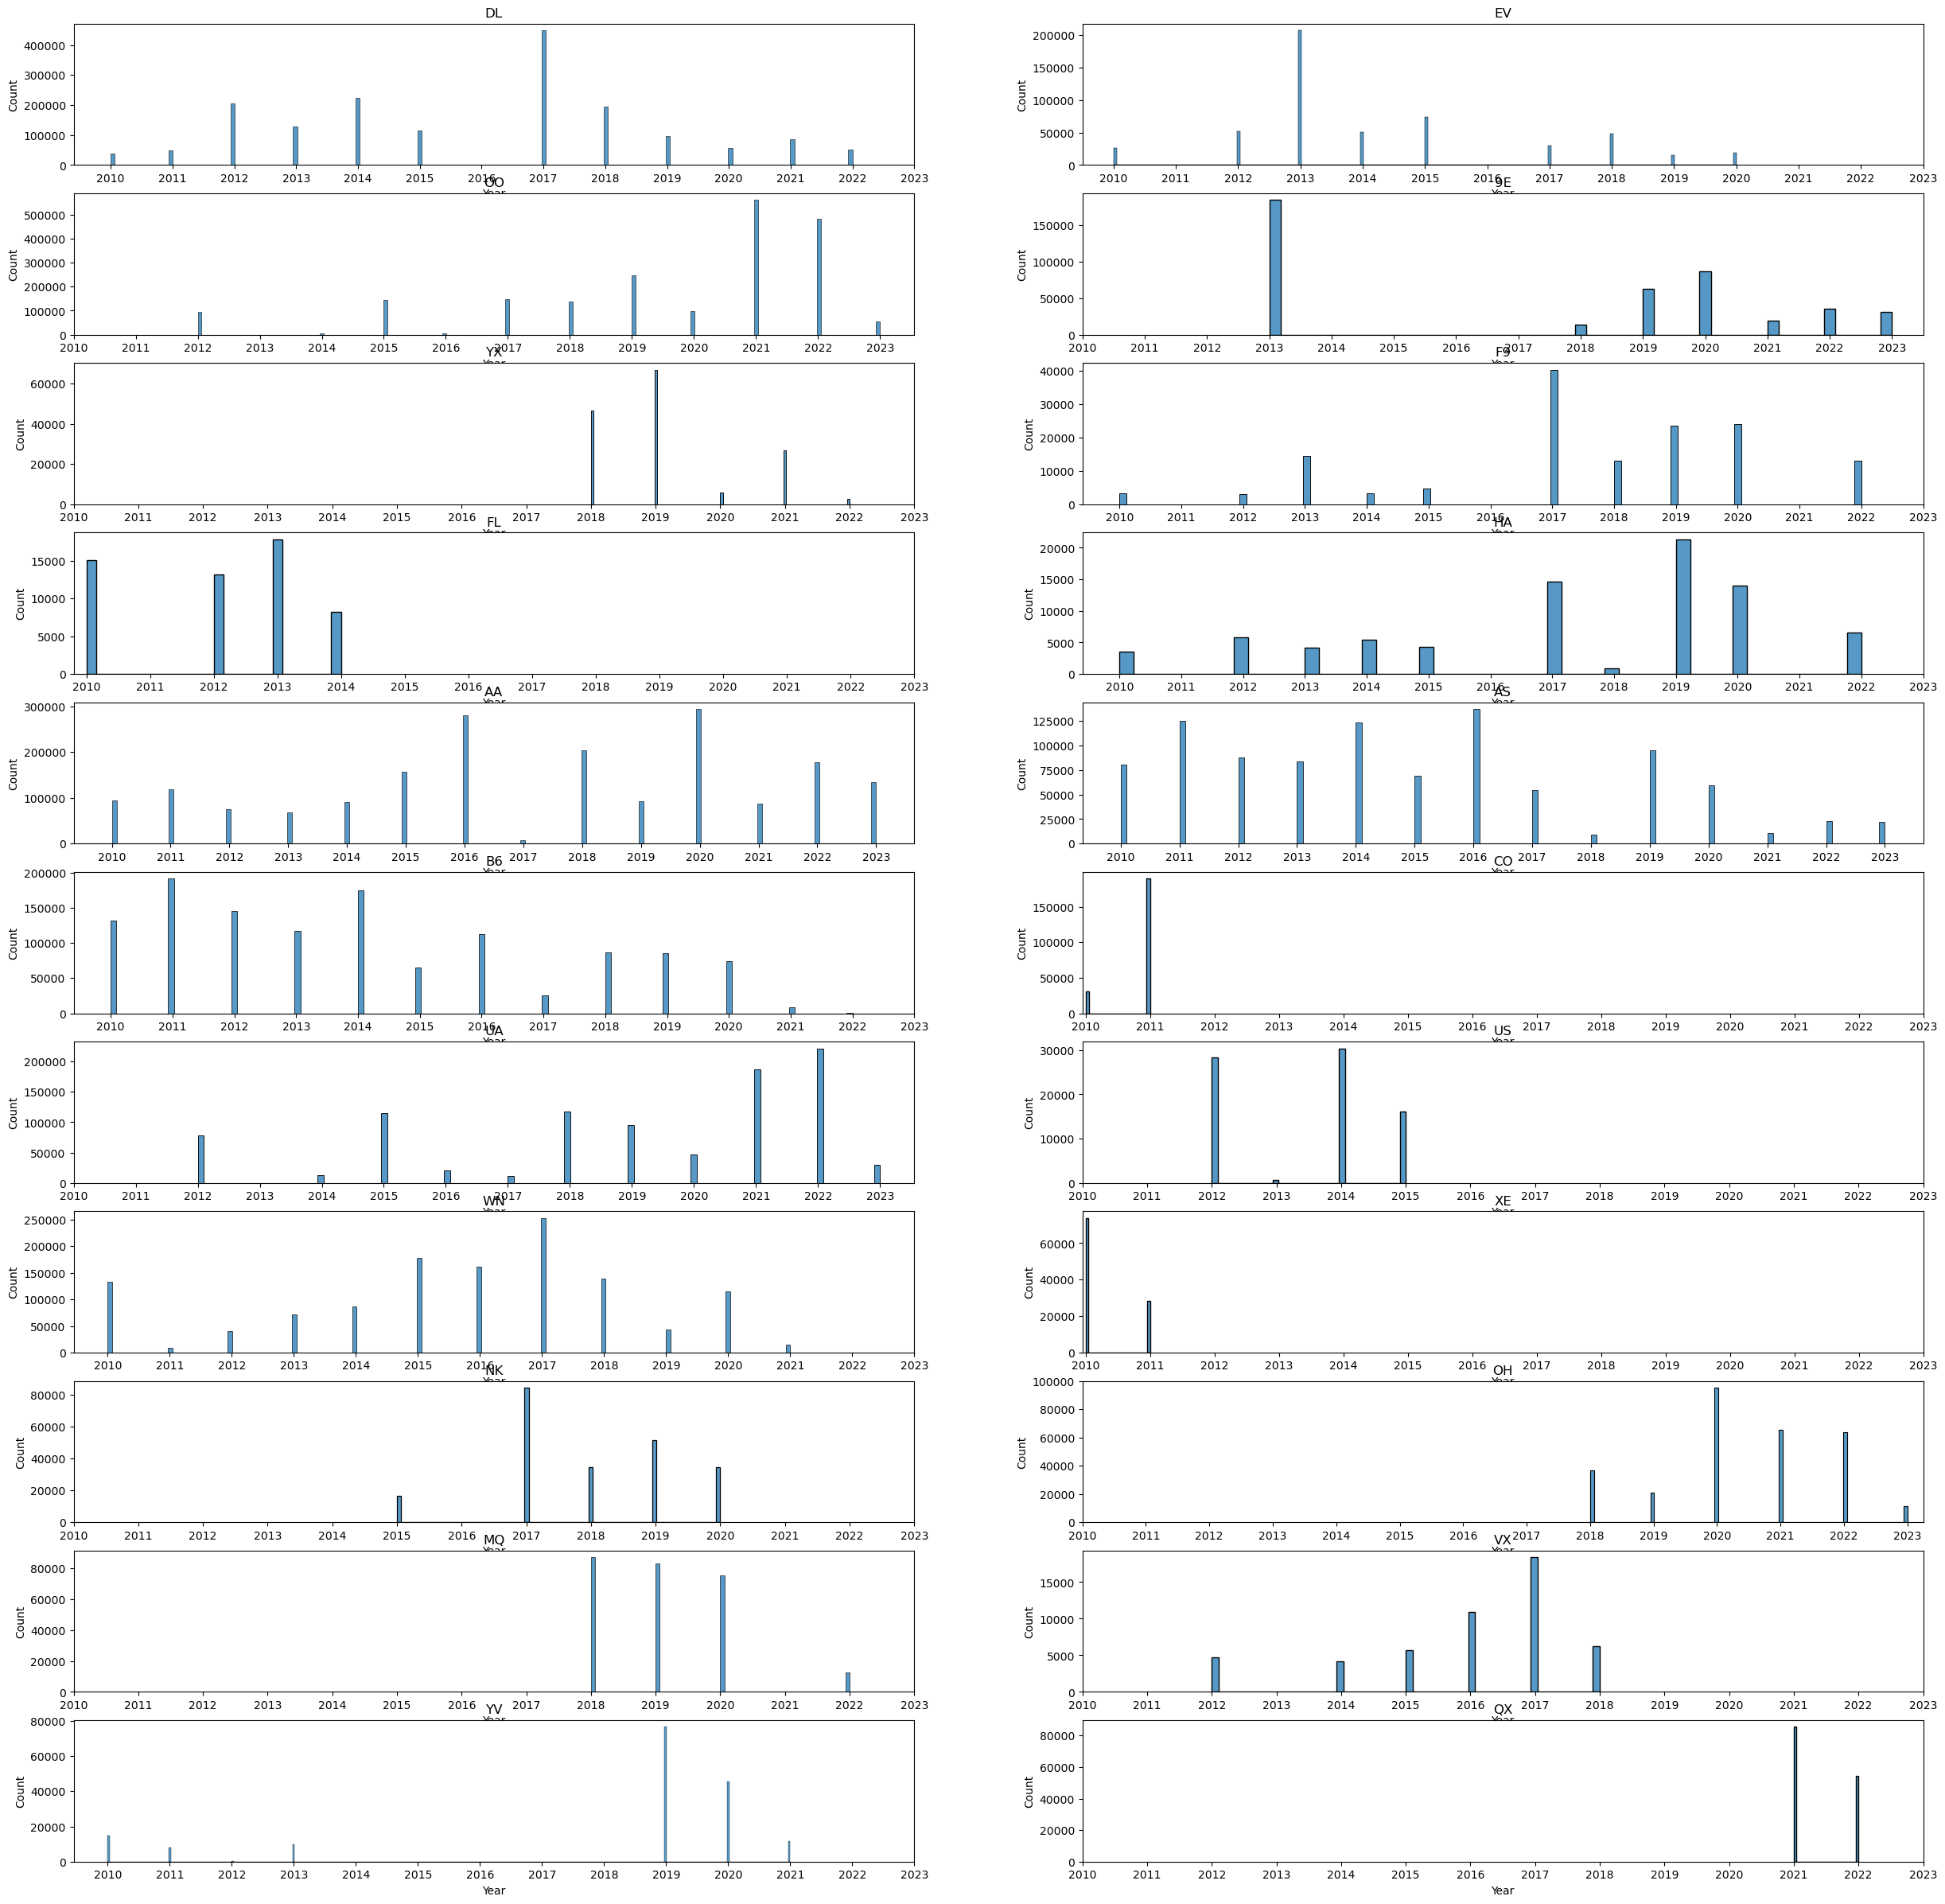

In [ ]:
fig,ax = plt.subplots(11,2,figsize=(30,30))
ax = ax.flatten()
for idx, air in enumerate(tst.Reporting_Airline.unique()):
    data=tst[tst['Reporting_Airline']==air]
    sns.histplot(data=data,
                 x='Year',
                 ax= ax[idx])
    ax[idx].set_title(air)
    ax[idx].set_xticks([x for x in range(2010,2024)])

In [ ]:
tst[tst['Reporting_Airline']=='DL'].groupby('Year').describe()

Quarter                                                  Month  \
         count      mean       std  min  25%  50%  75%  max     count   
Year                                                                    
2010   38329.0  4.000000  0.000000  4.0  4.0  4.0  4.0  4.0   38329.0   
2011   48632.0  2.213255  1.192925  1.0  1.0  2.0  3.0  4.0   48632.0   
2012  204748.0  2.742366  1.209802  1.0  2.0  3.0  4.0  4.0  204748.0   
2013  128967.0  2.187443  1.274764  1.0  1.0  2.0  4.0  4.0  128967.0   
2014  225014.0  2.570400  1.152911  1.0  2.0  2.0  4.0  4.0  225014.0   
2015  115307.0  2.173146  0.984900  1.0  1.0  3.0  3.0  3.0  115307.0   
2016      96.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0      96.0   
2017  448815.0  2.094616  1.046071  1.0  1.0  2.0  3.0  4.0  448815.0   
2018  195393.0  2.622694  0.970666  1.0  2.0  3.0  3.0  4.0  195393.0   
2019   96453.0  3.022104  0.378869  1.0  3.0  3.0  3.0  4.0   96453.0   
2020   57318.0  2.967986  0.882534  1.0  2.0  3.0  4.0  4.0   57318.0   
2021   85557.0  2.587713  1.497442  1.0  1.0  4.0  4.0  4.0   85557.0   
2022   50977.0  3.000000  0.000000  3.0  3.0  3.0  3.0  3.0   50977.0   

                                                        DayofMonth             \
           mean       std   min   25%   50%   75%   max      count       mean   
Year                                                                            
2010  10.000000  0.000000  10.0  10.0  10.0  10.0  10.0    38329.0  21.523677   
2011   5.683110  3.866198   1.0   2.0   5.0   9.0  12.0    48632.0   2.510076   
2012   7.307143  3.472804   2.0   4.0   7.0  11.0  12.0   204748.0   7.770928   
2013   6.051951  4.021571   1.0   3.0   5.0  11.0  12.0   128967.0  20.516946   
2014   6.518843  3.595702   1.0   4.0   6.0  10.0  12.0   225014.0   7.936982   
2015   5.319868  3.215276   1.0   2.0   8.0   8.0   9.0   115307.0  16.639094   
2016   2.000000  0.000000   2.0   2.0   2.0   2.0   2.0       96.0   1.000000   
2017   5.716843  3.491732   1.0   3.0   4.0   9.0  12.0   448815.0  15.343750   
2018   6.834631  3.095258   1.0   5.0   7.0   9.0  12.0   195393.0  16.599418   
2019   8.149378  1.220512   3.0   8.0   8.0   8.0  12.0    96453.0  14.910526   
2020   8.450382  2.673315   1.0   6.0   8.0  12.0  12.0    57318.0  13.226962   
2021   6.511378  4.771557   1.0   1.0  11.0  11.0  11.0    85557.0  14.087673   
2022   8.000000  0.000000   8.0   8.0   8.0   8.0   8.0    50977.0  15.817800   

                                              DayOfWeek                      \
            std   min   25%   50%   75%   max     count      mean       std   
Year                                                                          
2010   5.711016  12.0  17.0  21.0  26.0  31.0   38329.0  4.103446  1.923153   
2011   1.617052   1.0   1.0   2.0   3.0   7.0   48632.0  4.489349  2.095225   
2012   5.102122   1.0   4.0   7.0  11.0  30.0  204748.0  3.956576  1.986025   
2013   8.301972   1.0  18.0  22.0  27.0  31.0  128967.0  3.897772  1.957685   
2014   6.581563   1.0   3.0   6.0  10.0  31.0  225014.0  3.955585  2.026597   
2015   8.449563   1.0   9.0  17.0  24.0  31.0  115307.0  4.084479  2.013027   
2016   0.000000   1.0   1.0   1.0   1.0   1.0      96.0  1.000000  0.000000   
2017   8.717475   1.0   8.0  15.0  23.0  31.0  448815.0  4.011582  1.969664   
2018   8.720299   2.0   8.0  17.0  25.0  31.0  195393.0  3.932198  1.783191   
2019   8.932135   1.0   7.0  14.0  23.0  31.0   96453.0  4.061315  2.025394   
2020  10.519230   1.0   3.0  10.0  24.0  30.0   57318.0  4.029293  2.017353   
2021   9.049976   1.0   6.0  11.0  22.0  30.0   85557.0  3.999544  2.160278   
2022   8.952070   1.0   8.0  16.0  24.0  31.0   50977.0  3.791455  2.005045   

                              DOT_ID_Reporting_Airline                         \
      min  25%  50%  75%  max                    count     mean  std      min   
Year                                                                            
2010  1.0  3.0  4.0  6.0  7.0    

In [ ]:
df.groupby('Year').describe()

Quarter                                                Month       \
          count mean       std  min   25%  50%   75%  max      count mean   
Year                                                                        
2010  1200000.0  2.5  1.118034  1.0  1.75  2.5  3.25  4.0  1200000.0  6.5   
2011  1200000.0  2.5  1.118034  1.0  1.75  2.5  3.25  4.0  1200000.0  6.5   
2012  1200000.0  2.5  1.118034  1.0  1.75  2.5  3.25  4.0  1200000.0  6.5   
2013  1200000.0  2.5  1.118034  1.0  1.75  2.5  3.25  4.0  1200000.0  6.5   
2014  1200000.0  2.5  1.118034  1.0  1.75  2.5  3.25  4.0  1200000.0  6.5   
2015  1200000.0  2.5  1.118034  1.0  1.75  2.5  3.25  4.0  1200000.0  6.5   
2016  1200000.0  2.5  1.118034  1.0  1.75  2.5  3.25  4.0  1200000.0  6.5   
2017  1200000.0  2.5  1.118034  1.0  1.75  2.5  3.25  4.0  1200000.0  6.5   
2018  1200000.0  2.5  1.118034  1.0  1.75  2.5  3.25  4.0  1200000.0  6.5   
2019  1200000.0  2.5  1.118034  1.0  1.75  2.5  3.25  4.0  1200000.0  6.5   
2020  1200000.0  2.5  1.118034  1.0  1.75  2.5  3.25  4.0  1200000.0  6.5   
2021  1200000.0  2.5  1.118034  1.0  1.75  2.5  3.25  4.0  1200000.0  6.5   
2022  1200000.0  2.5  1.118034  1.0  1.75  2.5  3.25  4.0  1200000.0  6.5   
2023   300000.0  1.0  0.000000  1.0  1.00  1.0  1.00  1.0   300000.0  2.0   

                                           DayofMonth                       \
           std  min   25%  50%   75%   max      count       mean       std   
Year                                                                         
2010  3.452054  1.0  3.75  6.5  9.25  12.0  1200000.0  16.661597  8.764639   
2011  3.452054  1.0  3.75  6.5  9.25  12.0  1200000.0  15.289991  9.039332   
2012  3.452054  1.0  3.75  6.5  9.25  12.0  1200000.0  14.086023  8.750326   
2013  3.452054  1.0  3.75  6.5  9.25  12.0  1200000.0  16.277765  8.729147   
2014  3.452054  1.0  3.75  6.5  9.25  12.0  1200000.0  14.239771  9.001187   
2015  3.452054  1.0  3.75  6.5  9.25  12.0  1200000.0  15.390678  8.618967   
2016  3.452054  1.0  3.75  6.5  9.25  12.0  1200000.0  14.881077  8.617371   
2017  3.452054  1.0  3.75  6.5  9.25  12.0  1200000.0  15.218900  8.824277   
2018  3.452054  1.0  3.75  6.5  9.25  12.0  1200000.0  15.535452  8.689799   
2019  3.452054  1.0  3.75  6.5  9.25  12.0  1200000.0  15.324418  8.817881   
2020  3.452054  1.0  3.75  6.5  9.25  12.0  1200000.0  15.498558  8.968016   
2021  3.452054  1.0  3.75  6.5  9.25  12.0  1200000.0  16.004337  8.976888   
2022  3.452054  1.0  3.75  6.5  9.25  12.0  1200000.0  16.159243  8.840369   
2023  0.816498  1.0  1.00  2.0  3.00   3.0   300000.0  15.386087  8.863432   

                                  DayOfWeek                                \
      min  25%   50%   75%   max      count      mean       std  min  25%   
Year                                                                        
2010  1.0  9.0  17.0  24.0  31.0  1200000.0  3.953392  1.976772  1.0  2.0   
2011  1.0  7.0  15.0  23.0  31.0  1200000.0  3.981584  2.005193  1.0  2.0   
2012  1.0  7.0  13.0  21.0  31.0  1200000.0  3.953883  2.000297  1.0  2.0   
2013  1.0  9.0  17.0  24.0  31.0  1200000.0  3.929052  1.990868  1.0  2.0   
2014  1.0  6.0  13.0  22.0  31.0  1200000.0  3.956656  2.001708  1.0  2.0   
2015  1.0  8.0  15.0  23.0  31.0  1200000.0  3.930149  1.987342  1.0  2.0   
2016  1.0  7.0  15.0  22.0  31.0  1200000.0  3.956297  1.992426  1.0  2.0   
2017  1.0  8.0  15.0  23.0  31.0  1200000.0  3.958342  1.985481  1.0  2.0   
2018  1.0  8.0  15.0  23.0  31.0  1200000.0  3.870461  1.981836  1.0  2.0   
2019  1.0  8.0  15.0  23.0  31.0  1200000.0  3.953168  2.011554  1.0  2.0   
2020  1.0  7.0  16.0  23.0  31.0  1200000.0  4.019518  2.004536  1.0  2.0   
2021  1.0  8.0  16.0  24.0  31.0  1200000.0  3.996796  2.026456  1.0  2.0   
2022  1.0  9.0  16.0  24.0  31.0  1200000.0  3.962862  2.009909  1.0  2.0   
2023  1.0  8.0  15.0  23.0  31.0   300000.0  3.928467  1.975843  1.0  2.0   

                    DOT_ID_Reporting_Airline                 